In [45]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
architectures = ['test1-pol1', 'test2-pol1', 'test2-pol2']
policies = list(set([x for x in map(lambda y: y.split('-', 1)[1], architectures)]))
arch_pol_tupl_ls = [(x, y) for x, y in map(lambda x: x.split('-', 1), architectures)]
skip_layers_values = [1, 2, 3, 4, 8, 16, 32]
bench_types = ['quality', 'speed']
runs = 10

In [5]:
reports_list = os.listdir()

def printList(x):
    print()
    for entry in x:
        print(entry)
        
reports_list = list(filter(lambda x: 'speed' in x or 'quality' in x, sorted(reports_list)))
printList(reports_list)

speed_reports = list(filter(lambda x: 'speed' in x, reports_list))
quality_reports = list(filter(lambda x: 'quality' in x, reports_list))
print()
print('Speed reports vailable: ')
printList(speed_reports)
print()
print('Quality reports available:')
printList(quality_reports)


quality-densenet121-none-run.csv
quality-densenet121-skip-last-run.csv
quality-densenet121-skip-run.csv
quality-densenet169-none-run.csv
quality-densenet169-skip-run.csv
speed-resnet18-drop-rand-n-run.csv
speed-resnet18-none-run.csv

Speed reports vailable: 

speed-resnet18-drop-rand-n-run.csv
speed-resnet18-none-run.csv

Quality reports available:

quality-densenet121-none-run.csv
quality-densenet121-skip-last-run.csv
quality-densenet121-skip-run.csv
quality-densenet169-none-run.csv
quality-densenet169-skip-run.csv


Index(['run', 'skip_n', 'bench_type', 'arch', 'pol', 'prec', 'rec', 'acc',
       'f1', 'time'],
      dtype='object')
0      densenet121
1      densenet121
2      densenet121
3      densenet121
4      densenet121
          ...     
627    densenet169
628    densenet169
629    densenet169
630    densenet169
631    densenet169
Name: arch, Length: 632, dtype: object
No content found


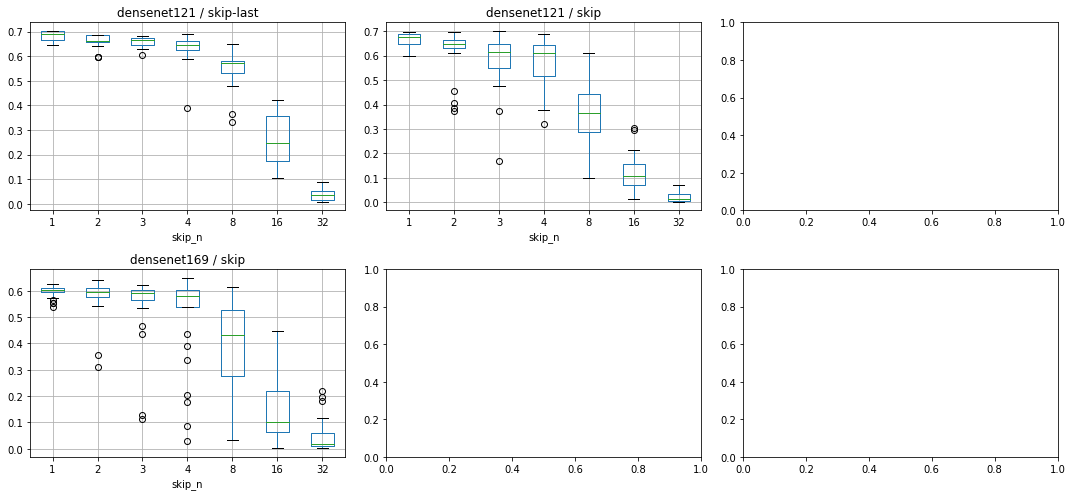

In [66]:
li = []

def getDataFrameFromReports(csv_files):
    li = []
    for entry in csv_files:
        df = pd.read_csv(entry)
        if len(df) == 0:
            print("No data found in", entry)
        li.append(df)
    return pd.concat(li, axis=0, ignore_index=True)


s_df = getDataFrameFromReports(speed_reports)
q_df = getDataFrameFromReports(quality_reports)

print(s_df.columns)
print(q_df['arch'])
def printBoxPlotForArchAndPol(data_frame, arch_name, policy_name, ax):
    df, an, pn = data_frame, arch_name, policy_name

    df = df.query(f'arch == "{an}"')
    df = df.query(f'pol == "{pn}"')
    if len(df) == 0:
        print("No content found")
        return
    #print(df)
    bp = df.boxplot(column=['acc'], by='skip_n', figsize=(8, 6), ax=ax)
    fig = np.asarray(bp).reshape(-1)[0].get_figure()
    fig.suptitle(f'')
    ax.set_title(f'{an} / {pn}')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))
#q_df.boxplot(column=['acc'], by=['skip_n'], ax=axes[0, 0])
printBoxPlotForArchAndPol(q_df, 'densenet121', 'skip-last', axes[0,0])
printBoxPlotForArchAndPol(q_df, 'densenet121', 'skip', axes[0,1])
printBoxPlotForArchAndPol(q_df, 'densenet169', 'skip-last', axes[1,0])
printBoxPlotForArchAndPol(q_df, 'densenet169', 'skip', axes[1,0])
fig.tight_layout()
plt.show()
#print(q_df)

In [68]:
s_df['arch'].unique()

array(['resnet18'], dtype=object)

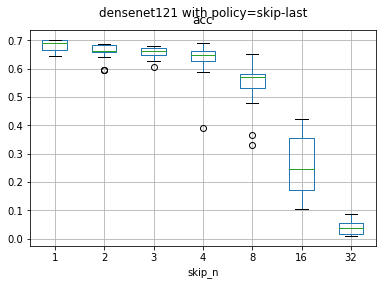

In [15]:
# skip last n layers
printBoxPlotForArchAndPol(q_df, 'densenet121', 'skip-last')

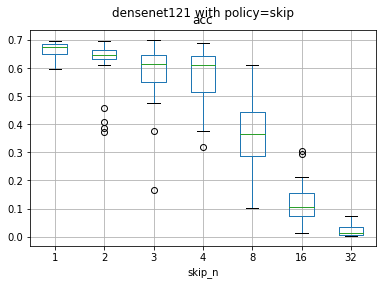

In [16]:
# skip random n layers
printBoxPlotForArchAndPol(q_df, 'densenet121', 'skip')

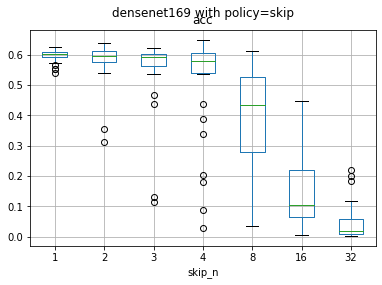

In [21]:
# skip random n layers
printBoxPlotForArchAndPol(q_df, 'densenet169', 'skip')

In [76]:
def executeQualityBench(arch_name, loader):
    prec = random.random()
    acc = random.random()
    rec = random.random()

    return prec, acc, rec

def executeSpeedBench(arch_name, loader):
    speed = random.random()
    return speed



d = {'run': [], 'skip_n': [], 'bench_type': [], 'arch': [], 'pol': [], 'prec': [], 'rec': [], 'acc': [], 'time': []}


loader = []

for bench_type in bench_types:
    for arch, pol in arch_pol_tupl_ls:
        for skip_n in skip_layers_values:
            for run in range(runs):
                prec = 0.0
                rec = 0.0
                acc = 0.0
                time = 0.0
                if bench_type == 'quality':
                    prec, acc, rec = executeQualityBench(f'{arch}-{pol}', loader)
                    #print(f'{run} - {skip_n} - {bench_type} - {arch} - {pol} - {prec:.6f} - {rec:.6f} - {acc:.6f}')
                elif bench_type == 'speed':
                    time = executeSpeedBench(f'{arch}-{pol}', loader)
                    #print(f'{run} - {skip_n} - {bench_type} - {arch} - {pol} - {time:.6f}')
                else:
                    raise ValueError('Benchmark type not supported')
                
                d['run'].append(run)
                d['skip_n'].append(skip_n)
                d['bench_type'].append(bench_type)
                d['arch'].append(arch)
                d['pol'].append(pol)
                d['prec'].append(prec)
                d['rec'].append(rec)
                d['acc'].append(acc)
                d['time'].append(time)

In [81]:
df = pd.DataFrame(data=d)
reports_path = os.path.join(os.getcwd())
print(reports_path)
if not os.path.isdir:
    os.mkdir(reports_path)
df.to_csv(os.path.join(reports_path, 'run.csv'), index=False)
columns = list(d.keys())
print(columns)

/home/alex/Projects/Studium/anytimeDnn/reports
['run', 'skip_n', 'bench_type', 'arch', 'pol', 'prec', 'rec', 'acc', 'time']


In [54]:
quality_df = df.query('bench_type == "quality"')
speed_df = df.query('bench_type == "speed"')

Plot for pol1
Plot for pol2


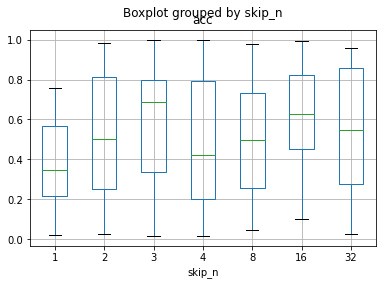

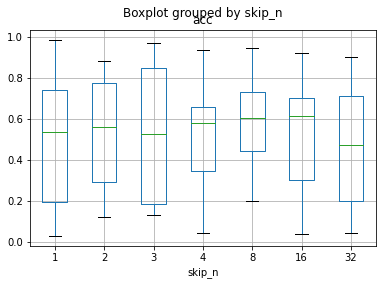

In [73]:
for policy in policies:
    t_df = quality_df.query(f'pol == "{policy}"')
    print(f'Plot for {policy}')
    t_df.boxplot(column='acc', by='skip_n')